# Epilepsy Convulsion Recognition with the InceptionTime SageMaker Algorithm

**Dataset link:** https://www.timeseriesclassification.com/description.php?Dataset=Epilepsy

**Blog post:**

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Classification (Inception) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-omz7rumnllmla).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
# SageMaker algorithm ARN from AWS Marketplace
algo_arn = "arn:aws:sagemaker:<...>"

In [2]:
import io
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Data preparation

Define a function for reading and preparing the data.

In [3]:
def read_data(dimension, split):
    
    # load the data
    df = pd.DataFrame(data=arff.loadarff(f"EpilepsyDimension{dimension}_{split}.arff")[0])
    
    # extract the features and labels
    features, labels = df.iloc[:, :-1], df.iloc[:, -1:]
    
    # rename the features
    features.columns = [f"x_{i}" for i in range(1, 1 + features.shape[1])]
    
    # one-hot encode the labels
    ohe = OneHotEncoder(sparse_output=False).fit(labels)
    labels = pd.DataFrame(data=ohe.transform(labels), columns=[f'y_{c.decode("utf-8")}' for c in ohe.categories_[0]])
    
    # merge the labels and features
    data = labels.join(features)
    
    # add the sample ids
    data.insert(0, "sample", range(1, 1 + len(df)))
    
    # add the feature ids
    data.insert(1, "feature", dimension)
    
    return data

#### 2.1 Training dataset

Load the training data.

In [4]:
training_dataset = pd.concat([read_data(d, "TRAIN") for d in range(1, 4)]).sort_values(by=["sample", "feature"], ignore_index=True)

In [5]:
training_dataset.shape

(411, 212)

In [6]:
training_dataset.head()

,sample,feature,y_EPILEPSY,y_RUNNING,y_SAWING,y_WALKING,x_1,x_2,x_3,x_4,...,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_204,x_205,x_206
0,1,1,1.0,0.0,0.0,0.0,0.35,0.40,0.44,0.47,...,0.51,0.51,0.50,0.55,0.54,0.58,0.61,0.62,0.65,0.69
1,1,2,1.0,0.0,0.0,0.0,0.22,0.01,-0.71,-0.33,...,-0.81,-0.05,0.42,-0.83,-1.46,-0.88,-0.04,0.72,-0.90,-1.30
2,1,3,1.0,0.0,0.0,0.0,0.55,0.51,0.52,0.44,...,0.56,0.66,0.60,0.42,0.42,0.53,0.54,0.50,0.55,0.54
3,2,1,1.0,0.0,0.0,0.0,-0.91,-0.92,-0.95,-0.95,...,-0.46,-0.51,-0.56,-0.58,-0.61,-0.56,-0.56,-0.47,-0.45,-0.45
4,2,2,1.0,0.0,0.0,0.0,-0.05,-0.02,0.01,0.01,...,0.23,0.38,0.45,0.30,0.35,0.58,0.69,0.88,0.80,0.76


Visualize the training data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


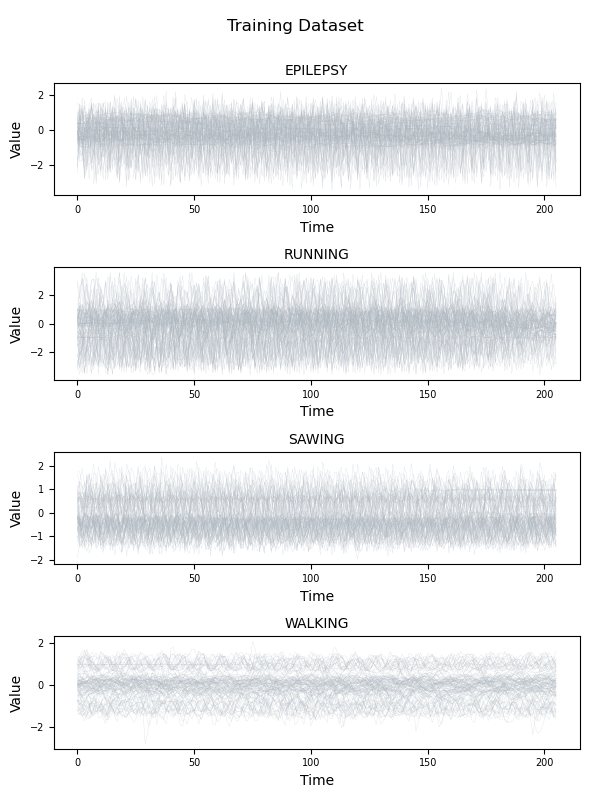

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 8))
for i in range(4):
    axs[i].plot(training_dataset[training_dataset.iloc[:, i + 2] == 1].iloc[:, 6:].transpose().values, color="#AFB8C1", lw=0.2, alpha=0.5)
    axs[i].set_title(f"{training_dataset.columns[i + 2].replace('y_', '')}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

Upload the training data to S3.

In [8]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="Epilepsy_train.csv"
)

In [9]:
training_data

's3://sagemaker-eu-west-1-661670223746/Epilepsy_train.csv'

#### 2.2 Test dataset

Load the test data.

In [10]:
test_dataset = pd.concat([read_data(d, "TEST") for d in range(1, 4)]).sort_values(by=["sample", "feature"], ignore_index=True)

In [11]:
test_dataset.shape

(414, 212)

In [12]:
test_dataset.head()

,sample,feature,y_EPILEPSY,y_RUNNING,y_SAWING,y_WALKING,x_1,x_2,x_3,x_4,...,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_204,x_205,x_206
0,1,1,1.0,0.0,0.0,0.0,0.60,0.60,0.60,0.61,...,-0.77,-0.75,-0.70,-0.68,-0.69,-0.70,-0.70,-0.69,-0.70,-0.70
1,1,2,1.0,0.0,0.0,0.0,-1.72,-1.28,1.49,0.78,...,0.68,1.22,0.28,-1.82,-1.13,1.49,0.85,-0.73,-1.76,1.03
2,1,3,1.0,0.0,0.0,0.0,-0.47,0.02,-0.17,-0.25,...,-0.30,-1.49,-0.83,-0.50,-0.49,-0.50,-0.53,-0.36,-0.51,-0.57
3,2,1,1.0,0.0,0.0,0.0,-0.35,-0.44,-0.86,-0.64,...,-0.03,-0.08,-0.06,-0.01,-0.05,-0.03,-0.11,-0.18,-0.16,-0.14
4,2,2,1.0,0.0,0.0,0.0,-0.99,-2.30,-0.57,0.91,...,-0.24,-0.32,-0.29,-0.28,-0.30,-0.27,-0.22,-0.25,-0.32,-0.34


Visualize the test data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


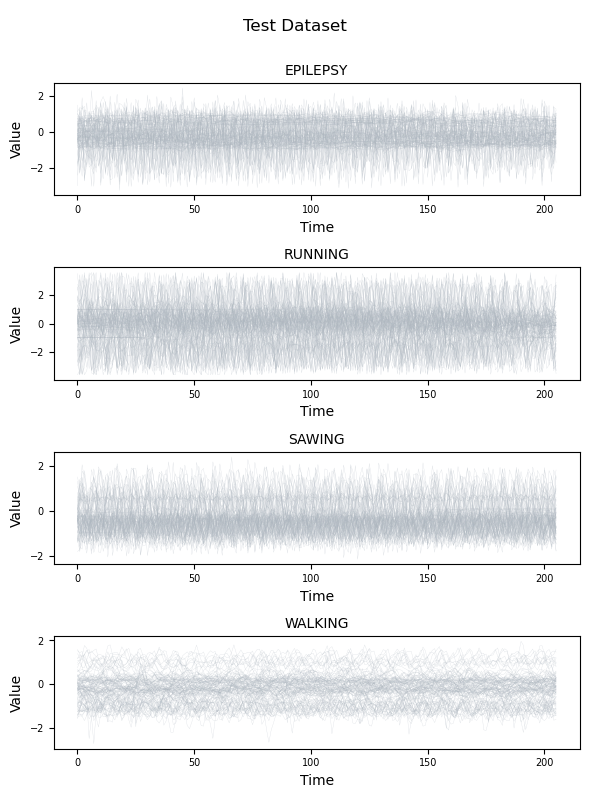

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 8))
for i in range(4):
    axs[i].plot(test_dataset[test_dataset.iloc[:, i + 2] == 1].iloc[:, 6:].transpose().values, color="#AFB8C1", lw=0.2, alpha=0.5)
    axs[i].set_title(f"{test_dataset.columns[i + 2].replace('y_', '')}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

Upload the test data to S3, make sure to remove the class labels.

In [14]:
test_inputs = test_dataset[["sample", "feature"] + [c for c in test_dataset.columns if c.startswith("x")]]

In [15]:
test_inputs.head()

,sample,feature,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_204,x_205,x_206
0,1,1,0.60,0.60,0.60,0.61,0.59,0.59,0.59,0.60,...,-0.77,-0.75,-0.70,-0.68,-0.69,-0.70,-0.70,-0.69,-0.70,-0.70
1,1,2,-1.72,-1.28,1.49,0.78,-0.71,-1.62,1.17,1.17,...,0.68,1.22,0.28,-1.82,-1.13,1.49,0.85,-0.73,-1.76,1.03
2,1,3,-0.47,0.02,-0.17,-0.25,-0.25,-0.40,0.24,0.51,...,-0.30,-1.49,-0.83,-0.50,-0.49,-0.50,-0.53,-0.36,-0.51,-0.57
3,2,1,-0.35,-0.44,-0.86,-0.64,-0.45,-0.25,-0.08,-0.07,...,-0.03,-0.08,-0.06,-0.01,-0.05,-0.03,-0.11,-0.18,-0.16,-0.14
4,2,2,-0.99,-2.30,-0.57,0.91,0.65,-1.96,-1.77,0.07,...,-0.24,-0.32,-0.29,-0.28,-0.30,-0.27,-0.22,-0.25,-0.32,-0.34


In [16]:
test_outputs = test_dataset[["sample"] + [c for c in test_dataset.columns if c.startswith("y")]].drop_duplicates(ignore_index=True)

In [17]:
test_outputs.head()

,sample,y_EPILEPSY,y_RUNNING,y_SAWING,y_WALKING
0,1,1.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0
4,5,1.0,0.0,0.0,0.0


In [18]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_inputs.to_csv(index=False),
    bucket=bucket,
    key="Epilepsy_test.csv"
)

In [19]:
test_data

's3://sagemaker-eu-west-1-661670223746/Epilepsy_test.csv'

### 3. Training

Fit the model to the training data.

In [20]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "filters": 32,
        "depth": 6,
        "models": 5,
        "batch-size": 256,
        "lr": 0.001,
        "epochs": 100,
        "task": "multiclass"
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: inception-time-v1-8-2024-08-16-16-42-13-122


2024-08-16 16:42:13 Starting - Starting the training job...
2024-08-16 16:42:31 Starting - Preparing the instances for training...
2024-08-16 16:43:09 Downloading - Downloading the training image..................
2024-08-16 16:46:05 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2024-08-16 16:46:25,054 sagemaker-training-toolkit INFO  

### 4. Inference

Generate the test set predictions.

In [21]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: inception-time-v1-8-2024-08-16-16-55-32-592


.........

INFO:sagemaker:Creating model with name: inception-time-v1-8-2024-08-16-16-55-32-2024-08-16-16-56-18-061


INFO:sagemaker:Creating transform job with name: inception-time-v1-8-2024-08-16-16-56-18-734


2024-08-16T17:03:53,338 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-08-16T17:03:53,340 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2024-08-16T17:03:53,411 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2024-08-16T17:03:53,508 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.11.0
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Infe

Load the test set predictions from S3.

In [22]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/Epilepsy_test.csv.out"
)

In [23]:
predictions = pd.read_csv(io.StringIO(predictions))

In [24]:
predictions.shape

(138, 9)

In [25]:
predictions.head()

,sample,y_EPILEPSY,y_RUNNING,y_SAWING,y_WALKING,p_EPILEPSY,p_RUNNING,p_SAWING,p_WALKING
0,1,1,0,0,0,0.999901,0.000052,0.000027,0.000020
1,2,1,0,0,0,0.999804,0.000127,0.000035,0.000034
2,3,1,0,0,0,0.997207,0.000403,0.001959,0.000431
3,4,1,0,0,0,0.999812,0.000085,0.000068,0.000035
4,5,1,0,0,0,0.999640,0.000203,0.000102,0.000055


Calculate the classification metrics.

In [26]:
metrics = pd.DataFrame(columns=[c.replace("y_", "") for c in test_outputs.columns if c.startswith("y")])
for c in metrics.columns:
    metrics[c] = {
        "Accuracy": accuracy_score(y_true=test_outputs[f"y_{c}"], y_pred=predictions[f"y_{c}"]),
        "ROC-AUC": roc_auc_score(y_true=test_outputs[f"y_{c}"], y_score=predictions[f"p_{c}"]),
        "Precision": precision_score(y_true=test_outputs[f"y_{c}"], y_pred=predictions[f"y_{c}"]),
        "Recall": recall_score(y_true=test_outputs[f"y_{c}"], y_pred=predictions[f"y_{c}"]),
        "F1": f1_score(y_true=test_outputs[f"y_{c}"], y_pred=predictions[f"y_{c}"]),
    }

In [27]:
metrics

,EPILEPSY,RUNNING,SAWING,WALKING
Accuracy,0.971014,1.0,1.0,0.971014
ROC-AUC,0.996324,1.0,1.0,0.996521
Precision,0.941176,1.0,1.0,0.945946
Recall,0.941176,1.0,1.0,0.945946
F1,0.941176,1.0,1.0,0.945946


Delete the model.

In [28]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: inception-time-v1-8-2024-08-16-16-55-32-2024-08-16-16-56-18-061
